# 参加kaggle的泰坦尼克项目比赛

泰坦尼克生存是kaggle上的一个经典入门项目，参加这个比赛旨在让自己熟悉python常用的数据分析库，并对机器学习有个初步的了解

In [1]:
#导入后面用到的各种库
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve,auc
from sklearn.model_selection import learning_curve
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import validation_curve
import warnings
warnings.filterwarnings("ignore")

In [20]:
#读取分析文件
train_data = pd.read_csv('C:/Users/x/Desktop/study2/titanic/train.csv')
test_data = pd.read_csv('C:/Users/x/Desktop/study2/titanic/test.csv')

In [3]:
#查看训练数据的数据情况，Age列部分数据缺失，Cabin列大量缺失，Embarked列个别缺失
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [4]:
#查看测试数据的情况，Age列部分缺失，Fare列个别缺失，Cabin列大量缺失
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


下面分析一下各个变量对存活率的影响

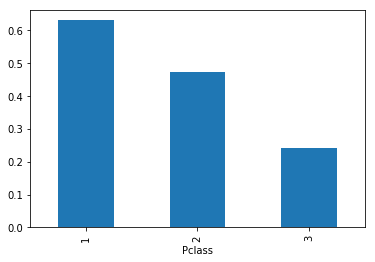

In [5]:
#根据Pclass进行分组，求出不同Pclass的存活率，绘制柱状图进行对比，可以看到1号舱的存活率最高，比3号高一倍多
train_data.groupby('Pclass')['Survived'].mean().plot.bar()

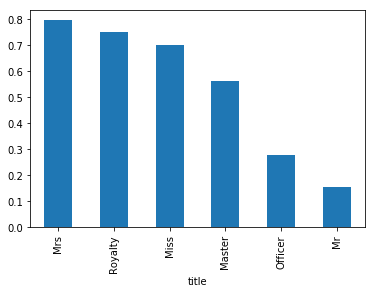

In [8]:
#下面分析Name列，虽然Name列都是唯一的姓名，但是我们通过提取姓名中的称呼，也能了解到它对存活率的影响
#通过提取称呼新建title列
train_data['title'] = train_data['Name'].map(lambda i:i.split('.')[0].split(',')[1].strip())
#因为title列中有部分称呼是相近的，我们将其合并
title_dict = {'Capt':'Officer','Col':'Officer','Major':'Officer','Dr':'Officer',
              'Rev':'Officer','Don':'Royalty','Sir':'Royalty','the Countess':'Royalty',
              'Dona':'Royalty','Lady':'Royalty','Mme':'Mrs','Ms':'Mrs','Mrs':'Mrs',
              'Mlle':'Miss','Miss':'Miss','Mr':'Mr','Master':'Master','Jonkheer':'Master'}
train_data['title'] = train_data['title'].map(title_dict)
#根据title列进行分组，绘制存活率的柱形图
#Mrs,Royalty,Miss,Master存活率相对较高，officer和Mr相对较低
train_data.groupby('title')['Survived'].mean().sort_values(ascending=False).plot.bar()

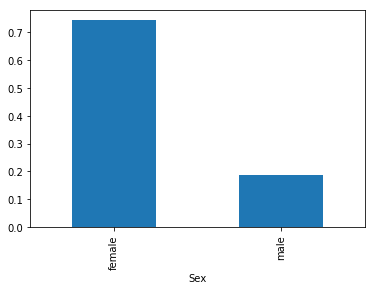

In [9]:
#下面分析Sex数据，直接根据Sex进行分组，查看存活率情况
#女性的存活率大大高出男性
train_data.groupby('Sex')['Survived'].mean().plot.bar()

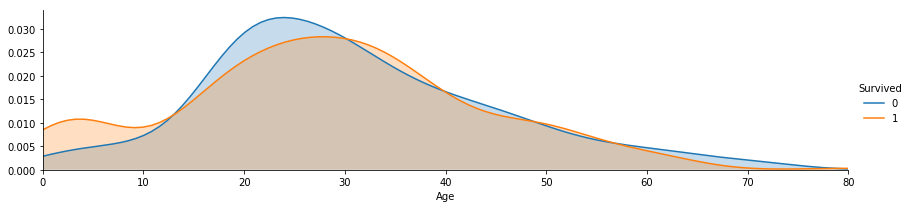

In [10]:
#接下来了解一下年龄和存活的关系，因为年龄是个连续变量，我们这里通过核密度图来观察
#从图中可以看出，约12岁以下的儿童的存活率是较高的
facet = sns.FacetGrid(train_data,hue='Survived',aspect=4)
facet.map(sns.kdeplot,'Age',shade=True)
facet.set(xlim=(0,train_data.Age.max()))
facet.add_legend()

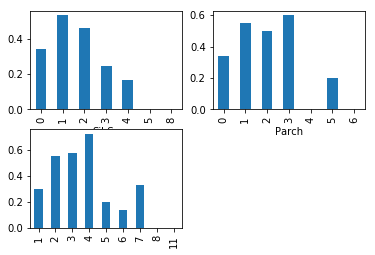

In [12]:
#再来分析SibSp和Parch以及两者合并后的存活情况
#这里绘制了三个柱状图来观察
#兄弟姐妹1-2个，父母子女1-3个，家庭规模2-4人的情况下，存活率较高
fig = plt.figure()
ax1 = fig.add_subplot(221)
train_data.groupby('SibSp')['Survived'].mean().plot.bar()
ax2 = fig.add_subplot(222)
train_data.groupby('Parch')['Survived'].mean().plot.bar()
ax3 = fig.add_subplot(223)
family = train_data.SibSp + train_data.Parch + 1
train_data.groupby(family)['Survived'].mean().plot.bar()

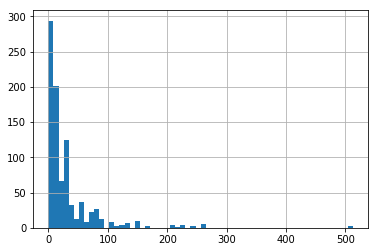

In [13]:
#分析Fare数据
#查看票价分布的直方图，绝大部分的票价都在50以下
train_data.Fare.hist(bins=60)

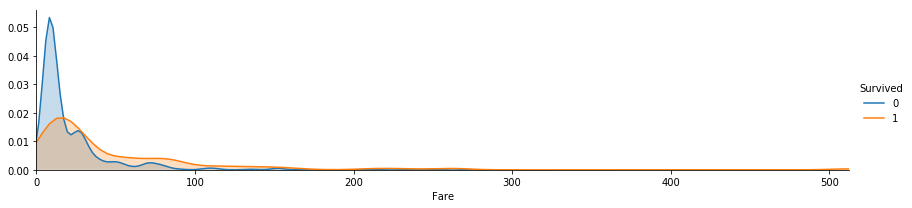

In [15]:
#绘制核密度图查看票价对应的存活情况，可以看到票价越高对应存活率也越高
facet = sns.FacetGrid(train_data,hue='Survived',aspect=4)
facet.map(sns.kdeplot,'Fare',shade=True)
facet.set(xlim=(0,train_data.Fare.max()))
facet.add_legend()

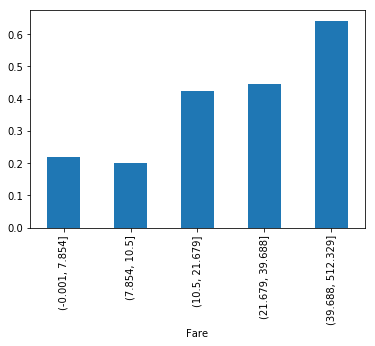

In [16]:
#将票价分割为若干个区间，查看每个区间的存活率
fare_cut = pd.qcut(train_data.Fare,5)    #分为数量相等的5个区间
#票价更高的存活率相对更高
train_data.groupby(fare_cut)['Survived'].mean().plot.bar()

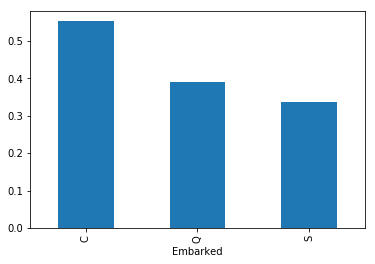

In [5]:
#分析登船点Embarked对存活的影响，C港登船的人存活率相对较高
train_data.groupby('Embarked')['Survived'].mean().plot.bar()

In [ ]:
#由于Cabin的缺失数据过多，这里就不对其进行分析了，特征工程处理时会将其删除

In [20]:
#对各变量分析完毕，生存率影响主要因素有舱位，称呼，性别，年龄，家庭规模，票价，上船地点这几个，下面进行特征工程
train_df = pd.read_csv('C:/Users/x/Desktop/study2/titanic/train.csv')
test_df = pd.read_csv('C:/Users/x/Desktop/study2/titanic/test.csv')
test_df['Survived'] = 0    #给测试数据新增Survived列，用0填充
df = pd.concat([train_df,test_df])     #合并测试和训练数据
df.info()     

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       1309 non-null int64
Ticket         1309 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 132.9+ KB


In [21]:
#缺失的Embarked用众数进行填充
df.Embarked.fillna(df.Embarked.mode()[0],inplace=True)

In [22]:
#因为Embarked是分类数据，通过get_dummies将其转为哑变量，并将原数据one-hot编码
embarked_dummy = pd.get_dummies(df.Embarked,prefix='Embarked')
df = pd.concat([df,embarked_dummy],axis=1)
df.Embarked = pd.factorize(df.Embarked)[0]

In [24]:
#Cabin列由于缺失过多，直接舍弃
df.drop('Cabin',axis=1,inplace=True)

In [35]:
#Fare列只有一个缺失值，用该乘客船舱对应的票价均值进行填充
df.Fare.fillna(df.groupby('Pclass')['Fare'].transform('mean').loc[df.Fare.isnull()].values[0],inplace=True)

In [37]:
#将票价分为四个区间，并转为哑变量
fare_dummy = pd.get_dummies(pd.qcut(df.Fare,4),prefix='Fare')
df = pd.concat([df,fare_dummy],axis=1)

In [69]:
#Fare是连续变量且分布较宽，对其进行标准化
scale_fare = preprocessing.StandardScaler().fit(df.Fare.values.reshape(-1,1))
df.Fare = scale_fare.transform(df.Fare.values.reshape(-1,1))

In [41]:
#对Name进行处理，提取称呼，转为哑变量，原列one-hot编码
df['title'] = df.Name.map(lambda x:x.split('.')[0].split(',')[1].strip())
title_dict = {'Capt':'Officer','Col':'Officer','Major':'Officer','Dr':'Officer',
              'Rev':'Officer','Don':'Royalty','Sir':'Royalty','the Countess':'Royalty',
              'Dona':'Royalty','Lady':'Royalty','Mme':'Mrs','Ms':'Mrs','Mrs':'Mrs',
              'Mlle':'Miss','Miss':'Miss','Mr':'Mr','Master':'Master','Jonkheer':'Master'}
df['title'] = df['title'].map(title_dict)
title_dummy = pd.get_dummies(df.title,prefix='title')
df = pd.concat([df,title_dummy],axis=1)
df.title = pd.factorize(df.title)[0]

In [43]:
#将SibSp和Parch列合并为family列，根据人数分为三类
df['family_num'] = df.SibSp + df.Parch + 1
df['family_type'] = 0
df['family_type'][df.family_num == 1] = 'small_family'
df['family_type'][(df.family_num < 5) & (df.family_num >1)] = 'middle_family'
df['family_type'][df.family_num >=5 ] = 'big_family'
family_type_dummy = pd.get_dummies(df.family_type)
df = pd.concat([df,family_type_dummy],axis=1)
df.family_type = pd.factorize(df.family_type)[0]

In [45]:
#处理Pclass列，将其转为哑变量，原来的数据one-hot编码
pclass_dummy = pd.get_dummies(df.Pclass,prefix='Pclass')
df = pd.concat([df,pclass_dummy],axis=1)
df.Pclass = pd.factorize(df.Pclass)[0]

In [46]:
#处理Sex变量，转为哑变量，原数据factorize
sex_dummy = pd.get_dummies(df.Sex,prefix='Sex')
df = pd.concat([df,sex_dummy],axis=1)
df.Sex = pd.factorize(df.Sex)[0]

In [88]:
#Age列缺少了部分数据，这里通过建立模型来预测缺失的Age数据
age_notnull = df[df.Age.notnull()]
age_null = df[df.Age.isnull()]
age_factor = age_notnull[['Age','Parch','Pclass','SibSp','Fare','title','family_num','family_type','Sex']]
rf = RandomForestRegressor(n_estimators=1000,random_state=0)     #建立随机森林模型
rf.fit(age_factor.drop(['Age'],axis=1),age_factor.Age)    #训练模型
age_predict = rf.predict(age_null[['Parch','Pclass','SibSp','Fare','title','family_num','family_type','Sex']])     #预测缺失年龄
df.Age.loc[df.Age.isnull()] = age_predict      #用预测值填充缺失部分

In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 35 columns):
Age                       1309 non-null float64
Embarked                  1309 non-null int64
Fare                      1309 non-null float64
Name                      1309 non-null object
Parch                     1309 non-null int64
PassengerId               1309 non-null int64
Pclass                    1309 non-null int64
Sex                       1309 non-null int64
SibSp                     1309 non-null int64
Survived                  1309 non-null int64
Ticket                    1309 non-null object
Embarked_C                1309 non-null uint8
Embarked_Q                1309 non-null uint8
Embarked_S                1309 non-null uint8
Fare_(-0.001, 7.896]      1309 non-null uint8
Fare_(7.896, 14.454]      1309 non-null uint8
Fare_(14.454, 31.275]     1309 non-null uint8
Fare_(31.275, 512.329]    1309 non-null uint8
title                     1309 non-null int64
title_Master  

In [96]:
#对Age也进行标准化处理
scale_age = preprocessing.StandardScaler().fit(df.Age.values.reshape(-1,1))
df.Age = scale_age.transform(df.Age.values.reshape(-1,1))

In [101]:
#至此，特征工程已经处理完毕，然后进行建模，先选取需要的数据
df_train = df.drop(['Name','PassengerId','Ticket'],axis=1)
X = df_train.drop(['Survived'],axis=1)[:891]
y = df_train.Survived[:891]

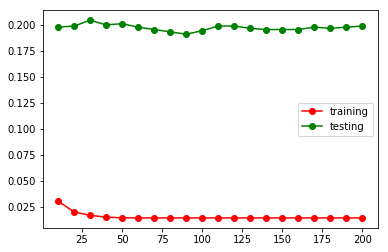

In [103]:
#使用validation_curve进行调参
model = RandomForestClassifier(random_state=0)
param_test = np.arange(10,210,10)
train_loss,test_loss = validation_curve(model,X,y,param_name='n_estimators',param_range=param_test,cv=10)
train_loss = 1 - np.mean(train_loss,axis=1)
test_loss = 1 - np.mean(test_loss,axis=1)
plt.plot(param_test,train_loss,'o-',color='r',label='training')
plt.plot(param_test,test_loss,'o-',color='g',label='testing')
plt.legend(loc='best')
plt.show()

In [104]:
#分别调整了参数n_estimators,max_features,min_samples_split,min_samples_leaf,max_depth
model = RandomForestClassifier(n_estimators=100,max_features=21,min_samples_split=2,min_samples_leaf=3,
                               max_depth=15,random_state=0,n_jobs=-1)
#对模型进行交叉验证
scores = cross_val_score(model,X,y,cv=10,scoring='accuracy')
print(scores)
print(scores.mean())
#模型的准确率在0.83左右

[0.8        0.84444444 0.75280899 0.85393258 0.8988764  0.85393258
 0.85393258 0.76404494 0.85393258 0.84090909]
0.8316814209510838


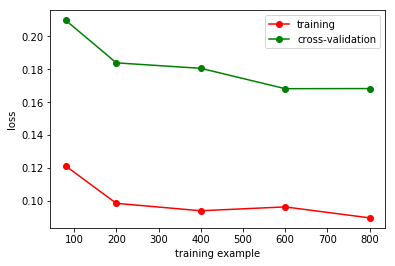

In [105]:
#接下来绘制学习曲线判断模型的拟合程度
train_sizes,train_loss,test_loss = learning_curve(model,X,y,cv=10,train_sizes=[0.1,0.25,0.5,0.75,1.0])
train_loss_mean = 1 - np.mean(train_loss,axis=1)
test_loss_mean = 1 - np.mean(test_loss,axis=1)
plt.plot(train_sizes,train_loss_mean,'o-',color='r',label='training')
plt.plot(train_sizes,test_loss_mean,'o-',color='g',label='cross-validation')
plt.xlabel('training example')
plt.ylabel('loss')
plt.legend(loc='best')

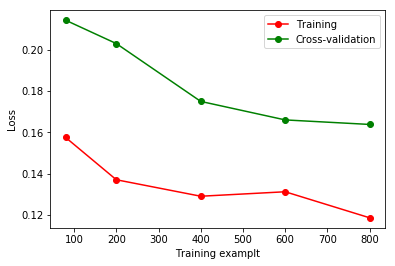

In [106]:
#似乎模型有些过拟合，试试融合模型
#融合模型的学习曲线
model = RandomForestClassifier(n_estimators=100,max_features=21,min_samples_split=2,min_samples_leaf=3,
                               max_depth=15,random_state=0,n_jobs=-1)
bagging_rf = BaggingClassifier(model,n_estimators=20,max_samples=0.8,max_features=1.0,bootstrap=True)
train_sizes,train_loss,test_loss=learning_curve(bagging_rf,X,y,cv=10,
                                                train_sizes=[0.1,0.25,0.5,0.75,1.0])
train_loss_mean=1-np.mean(train_loss,axis=1)
test_loss_mean=1-np.mean(test_loss,axis=1)
plt.plot(train_sizes,train_loss_mean,'o-',color='r',label='Training')
plt.plot(train_sizes,test_loss_mean,'o-',color='g',label='Cross-validation')
plt.xlabel('Training examplt')
plt.ylabel('Loss')
plt.legend(loc='best')

In [107]:
#融合模型的从曲线上看两曲线接近了一些，下面使用融合模型进行预测
bagging_rf.fit(X,y)
survived_predict = bagging_rf.predict(df_train.drop(['Survived'],axis=1)[891:])
df.loc[:,'Survived'].iloc[891:] = survived_predict
df.iloc[891:].loc[:,['PassengerId','Survived']].to_csv('C:/Users/x/Desktop/study2/titanic/predict10.csv')
#提交结果的分数是0.78947，名次在两千多名，约20%